In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'

# SED folder path
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Load the datasets
dataset_gt_train = np.load(data_dir + 'train_12000_stars_id_002_8bins.npy', allow_pickle=True)[()]
print(dataset_gt_train.keys())
dataset_gt_test = np.load(data_dir + 'test_1000_stars_id_002_8bins.npy', allow_pickle=True)[()]

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'packed_SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR'])


In [3]:
noisy = True
if noisy == True:
    obs_type = 'noisy_stars'
else:
    obs_type = 'stars'
train_star_offset = 2000

# Compute the star spectral energy distribution estimation
diff_train_gt = []
for i in range(train_star_offset,dataset_gt_train['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_gt_train['mono_psfs'][i]]))
    diff_train_gt.append((1-diff)/np.sum(1-diff))
diff_train_gt = np.array(diff_train_gt)
y_train_gt = dataset_gt_train['SED_ids'][train_star_offset:]
print(diff_train_gt.shape)
print(y_train_gt.__len__())

diff_test_gt = []
for i in range(dataset_gt_test['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_gt_test[obs_type][i])**2) for mono_psf in dataset_gt_test['mono_psfs'][i]]))
    diff_test_gt.append((1-diff)/np.sum(1-diff))
diff_test_gt = np.array(diff_test_gt)
y_test_gt = dataset_gt_test['SED_ids']
print(diff_test_gt.shape)
print(y_test_gt.__len__())

(10000, 8)
10000
(1000, 8)
1000


In [4]:
# Shuffle train and test datasets
diff_train_test = np.concatenate((diff_train_gt,diff_test_gt))
y_train_test = np.concatenate((y_train_gt,y_test_gt))

randomize = np.arange(len(diff_train_test))
np.random.shuffle(randomize)
diff_train_test_rnd = diff_train_test[randomize]
y_train_test_rnd = np.array(y_train_test)[randomize]

# Split the dataset into train and test
diff_train = diff_train_test_rnd[:diff_train_gt.shape[0]]
y_train = y_train_test_rnd[:diff_train_gt.shape[0]]
diff_test = diff_train_test_rnd[diff_train_gt.shape[0]:]
y_test = y_train_test_rnd[diff_train_gt.shape[0]:]

In [5]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(diff_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [6]:
predictions = clf.predict(diff_test)
predictions_proba = clf.predict_proba(diff_test)

In [7]:
p_tot = 0
p_tot_relaxed = 0
p_miss_tot = 0
p_miss_tot_relaxed = 0

for pred_proba, k in zip(predictions_proba, y_test):
	if np.abs(np.argmax(pred_proba) - k) <= 1:
		if k == 0:
			p_tot_relaxed += pred_proba[k] + pred_proba[k+1]
		elif k == 12:
			p_tot_relaxed += pred_proba[k] + pred_proba[k-1]
		else:
			p_tot_relaxed += pred_proba[k] + pred_proba[k-1] + pred_proba[k+1]
	if k == np.argmax(pred_proba):
		p_tot += pred_proba[k]
	if k != np.argmax(pred_proba):
		p_miss_tot += pred_proba[k]
	if np.abs(np.argmax(pred_proba) - k) >= 2:
		p_miss_tot_relaxed += pred_proba[k]

print('prediction confidence:', p_tot/len(predictions_proba))
print('prediction confidence relaxed:',p_tot_relaxed/len(predictions_proba))

print('missed prediction probability:', p_miss_tot/len(predictions_proba))
print('missed prediction probability relaxed:', p_miss_tot_relaxed/len(predictions_proba))


prediction confidence: 0.33485900273278246
prediction confidence relaxed: 0.7638308417947335
missed prediction probability: 0.11464474399283521
missed prediction probability relaxed: 0.012644133303037647


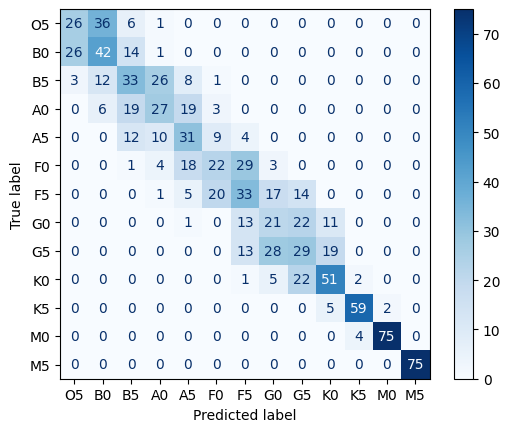

Accuracy:  0.524
Relaxed accuracy:  0.896


In [8]:
star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = np.trace(cm)/np.sum(cm)
relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)

print('Accuracy: ', accuracy)
print('Top-2 accuracy: ', relaxed_accuracy)

# Train with the approximated dataset

In [9]:
n_stars_list = [50, 100, 200, 500, 1000, 2000]
# Load the datasets
datasets_train = [np.load(data_dir + 'train_12000_stars_id_002_8bins_approx_{}_stars.npy'.format(n_stars), allow_pickle=True)[()] for n_stars in n_stars_list]
datasets_test = [np.load(data_dir + 'test_1000_stars_id_002_8bins_approx_{}_stars.npy'.format(n_stars), allow_pickle=True)[()] for n_stars in n_stars_list]


In [10]:
train_star_offset = 2000
diff_train_list = []
diff_test_list = []
y_train_list = []
y_test_list = []

# Compute the star spectral energy distribution estimation for each dataset
for dataset_train, dataset_test in zip(datasets_train, datasets_test):
    diff_train = []
    for i in range(train_star_offset, dataset_train['parameters']['n_stars']):
        diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_train['mono_psfs_approx'][i]]))
        diff_train.append((1-diff)/np.sum(1-diff))
    diff_train_list.append( np.array(diff_train) )
    y_train_list.append( dataset_train['SED_ids'][train_star_offset:])
    diff_test = []
    for i in range(dataset_test['parameters']['n_stars']):
        diff = (np.array([np.sum((mono_psf-dataset_gt_test[obs_type][i])**2) for mono_psf in dataset_test['mono_psfs_approx'][i]]))
        diff_test.append((1-diff)/np.sum(1-diff))
    diff_test_list.append( np.array(diff_test) )
    y_test_list.append( dataset_test['SED_ids'])


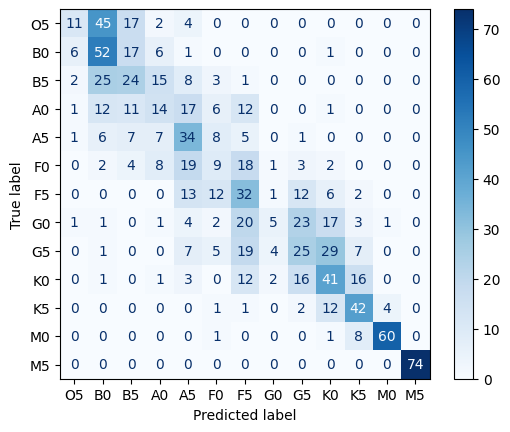

n_stars_train:  50
Accuracy:  0.423
Relaxed accuracy:  0.756
---------------------------------
prediction confidence: 0.21857918656202932
prediction confidence relaxed: 0.553190393636704
missed prediction probability: 0.10226061381902754
missed prediction probability relaxed: 0.024458408458764198


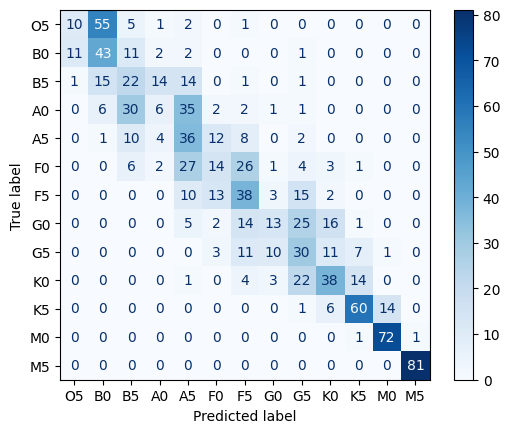

n_stars_train:  100
Accuracy:  0.463
Relaxed accuracy:  0.837
---------------------------------
prediction confidence: 0.2649706644984659
prediction confidence relaxed: 0.6534098114211859
missed prediction probability: 0.11197902737781108
missed prediction probability relaxed: 0.01733669172586152


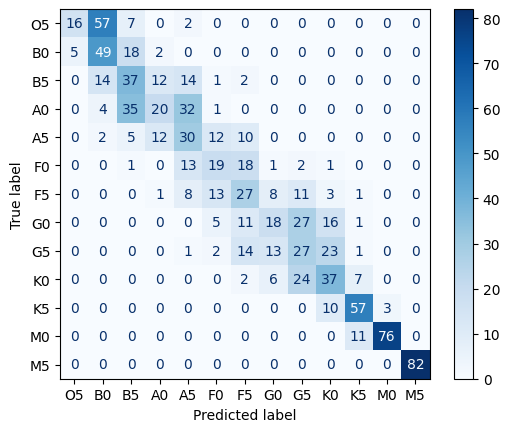

n_stars_train:  200
Accuracy:  0.495
Relaxed accuracy:  0.873
---------------------------------
prediction confidence: 0.3016153776647617
prediction confidence relaxed: 0.7240516594085981
missed prediction probability: 0.12230701163613929
missed prediction probability relaxed: 0.014464748931690826


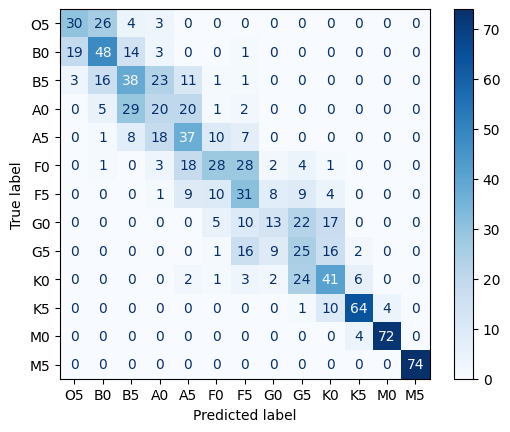

n_stars_train:  500
Accuracy:  0.521
Relaxed accuracy:  0.865
---------------------------------
prediction confidence: 0.3159363773581025
prediction confidence relaxed: 0.7195602027102175
missed prediction probability: 0.10728069818627513
missed prediction probability relaxed: 0.013743948194986573


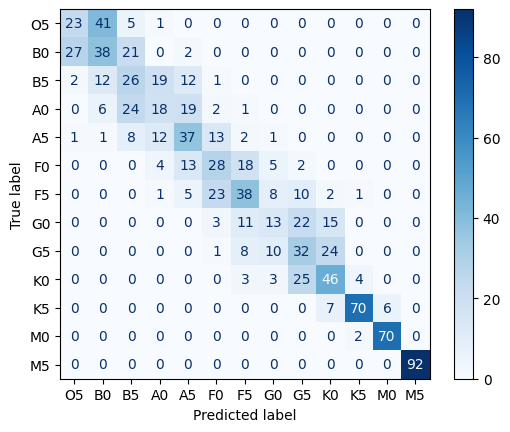

n_stars_train:  1000
Accuracy:  0.531
Relaxed accuracy:  0.892
---------------------------------
prediction confidence: 0.3404953059682876
prediction confidence relaxed: 0.7548270894902721
missed prediction probability: 0.11119115680955986
missed prediction probability relaxed: 0.012677249631543637


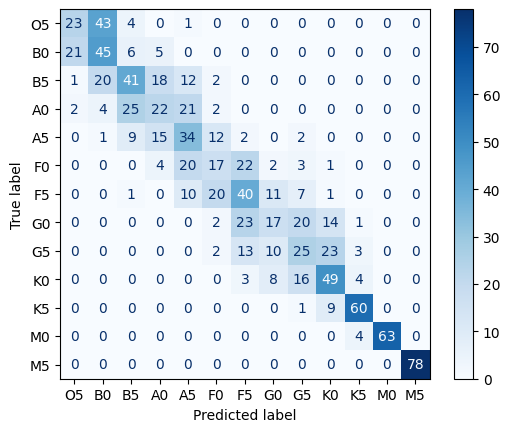

n_stars_train:  2000
Accuracy:  0.514
Relaxed accuracy:  0.877
---------------------------------
prediction confidence: 0.3127618296648247
prediction confidence relaxed: 0.7378087922511802
missed prediction probability: 0.1155989381551241
missed prediction probability relaxed: 0.012860823776600161


In [11]:
rand_runs = 10

rnd_cm_list = []
rnd_accuracy_list = []
rnd_relaxed_accuracy_list = []
rnd_confidence_list = []
rnd_confidence_relaxed_list = []
rnd_p_miss_list = []
rnd_p_miss_relaxed_list = []

for run in range(rand_runs):

    cm_list = []
    accuracy_list = []
    relaxed_accuracy_list = []
    confidence_list = []
    confidence_relaxed_list = []
    p_miss_list = []
    p_miss_relaxed_list = []

    for diff_train, y_train, diff_test, y_test, n_stars in zip(diff_train_list, y_train_list, diff_test_list, y_test_list ,n_stars_list):
        
        # Shuffle train and test datasets
        diff_train_test = np.concatenate((diff_train,diff_test))
        y_train_test = np.concatenate((y_train,y_test))
        randomize = np.arange(len(diff_train_test))
        np.random.shuffle(randomize)
        diff_train_test_rnd = diff_train_test[randomize]
        y_train_test_rnd = np.array(y_train_test)[randomize]
        # Split the dataset into train and test
        diff_train = diff_train_test_rnd[:diff_train.shape[0]]
        y_train = y_train_test_rnd[:diff_train.shape[0]]
        diff_test = diff_train_test_rnd[diff_train.shape[0]:]
        y_test = y_train_test_rnd[diff_train.shape[0]:]
        
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
        clf.fit(diff_train, y_train)
        predictions = clf.predict(diff_test)
        predictions_proba = clf.predict_proba(diff_test)

        cm = confusion_matrix(y_test, predictions)
        cm_list.append(cm)
        if run == rand_runs-1:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)
            disp.plot(cmap=plt.cm.Blues)
            plt.show()

        accuracy = np.trace(cm)/np.sum(cm)
        relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)
        accuracy_list.append(accuracy)
        relaxed_accuracy_list.append(relaxed_accuracy)
        if run == rand_runs-1:
            print('n_stars_train: ', n_stars)
            print('Accuracy: ', accuracy)
            print('Top-2 accuracy: ', relaxed_accuracy)
            print('---------------------------------')
        
        p_tot = 0
        p_tot_relaxed = 0
        p_miss_tot = 0
        p_miss_tot_relaxed = 0

        for pred_proba, k in zip(predictions_proba, y_test):
            if np.abs(np.argmax(pred_proba) - k) <= 1:
                if k == 0:
                    p_tot_relaxed += pred_proba[k] + pred_proba[k+1]
                elif k == 12:
                    p_tot_relaxed += pred_proba[k] + pred_proba[k-1]
                else:
                    p_tot_relaxed += pred_proba[k] + pred_proba[k-1] + pred_proba[k+1]
            if k == np.argmax(pred_proba):
                p_tot += pred_proba[k]
            if k != np.argmax(pred_proba):
                p_miss_tot += pred_proba[k]
            if np.abs(np.argmax(pred_proba) - k) >= 2:
                p_miss_tot_relaxed += pred_proba[k]


        confidence_list.append(p_tot/len(predictions_proba))
        confidence_relaxed_list.append(p_tot_relaxed/len(predictions_proba))
        p_miss_list.append(p_miss_tot/len(predictions_proba))
        p_miss_relaxed_list.append(p_miss_tot_relaxed/len(predictions_proba))

        if run == rand_runs-1:
            print('prediction confidence:', p_tot/len(predictions_proba))
            print('prediction confidence relaxed:',p_tot_relaxed/len(predictions_proba))
            print('missed prediction probability:', p_miss_tot/len(predictions_proba))
            print('missed prediction probability relaxed:', p_miss_tot_relaxed/len(predictions_proba))

    rnd_cm_list.append(cm_list)
    rnd_accuracy_list.append(accuracy_list)
    rnd_relaxed_accuracy_list.append(relaxed_accuracy_list)
    rnd_confidence_list.append(confidence_list)
    rnd_confidence_relaxed_list.append(confidence_relaxed_list)
    rnd_p_miss_list.append(p_miss_list)
    rnd_p_miss_relaxed_list.append(p_miss_relaxed_list)



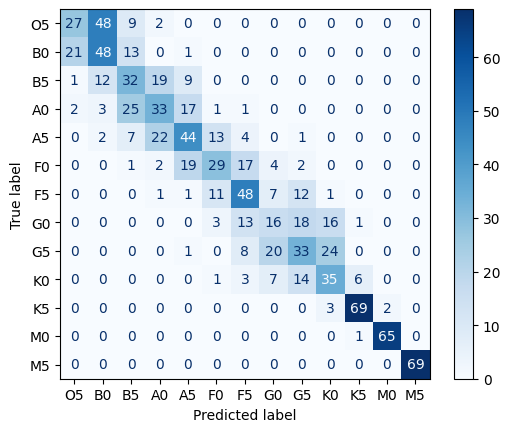

GT PSF model
Accuracy:  0.548
Relaxed accuracy:  0.893
---------------------------------
prediction confidence: 0.34041264548267436
prediction confidence relaxed: 0.7739864586881176
missed prediction probability: 0.11211174946531044
missed prediction probability relaxed: 0.01170081042613478


In [12]:
diff_train = diff_train_gt
y_train = dataset_gt_train['SED_ids'][train_star_offset:]
diff_test = diff_test_gt
y_test = dataset_gt_test['SED_ids']

rnd_cm_gt = []
rnd_accuracy_gt = []
rnd_relaxed_accuracy_gt = []
rnd_confidence_gt = []
rnd_confidence_relaxed_gt = []
rnd_p_miss_gt = []
rnd_p_miss_relaxed_gt = []

for run in range(rand_runs):
    # Shuffle train and test datasets
    diff_train_test = np.concatenate((diff_train,diff_test))
    y_train_test = np.concatenate((y_train,y_test))
    randomize = np.arange(len(diff_train_test))
    np.random.shuffle(randomize)
    diff_train_test_rnd = diff_train_test[randomize]
    y_train_test_rnd = np.array(y_train_test)[randomize]
    # Split the dataset into train and test
    diff_train = diff_train_test_rnd[:diff_train.shape[0]]
    y_train = y_train_test_rnd[:diff_train.shape[0]]
    diff_test = diff_train_test_rnd[diff_train.shape[0]:]
    y_test = y_train_test_rnd[diff_train.shape[0]:]

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
    clf.fit(diff_train, y_train)
    predictions = clf.predict(diff_test)
    predictions_proba = clf.predict_proba(diff_test)

    cm_gt = confusion_matrix(y_test, predictions)
    if run == rand_runs-1:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_gt, display_labels=star_class_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    accuracy_gt = np.trace(cm_gt)/np.sum(cm_gt)
    relaxed_accuracy_gt = (np.trace(cm_gt, offset=1) + np.trace(cm_gt, offset=-1) + np.trace(cm_gt) )/np.sum(cm_gt)

    if run == rand_runs-1:
        print('GT PSF model')
        print('Accuracy: ', accuracy_gt)
        print('Top-2 accuracy: ', relaxed_accuracy_gt)
        print('---------------------------------')

    p_tot_gt = 0
    p_tot_relaxed_gt = 0
    p_miss_tot_gt = 0
    p_miss_tot_relaxed_gt = 0
    for pred_proba, k in zip(predictions_proba, y_test):
        if np.abs(np.argmax(pred_proba) - k) <= 1:
            if k == 0:
                p_tot_relaxed_gt += pred_proba[k] + pred_proba[k+1]
            elif k == 12:
                p_tot_relaxed_gt += pred_proba[k] + pred_proba[k-1]
            else:
                p_tot_relaxed_gt += pred_proba[k] + pred_proba[k-1] + pred_proba[k+1]
        if k == np.argmax(pred_proba):
            p_tot_gt += pred_proba[k]
        if k != np.argmax(pred_proba):
            p_miss_tot_gt += pred_proba[k]
        if np.abs(np.argmax(pred_proba) - k) >= 2:
            p_miss_tot_relaxed_gt += pred_proba[k]

    confidence_gt = p_tot_gt/len(predictions_proba)
    confidence_relaxed_gt = p_tot_relaxed_gt/len(predictions_proba)
    p_miss_gt = p_miss_tot_gt/len(predictions_proba)
    p_miss_relaxed_gt = p_miss_tot_relaxed_gt/len(predictions_proba)

    if run == rand_runs-1:
        print('prediction confidence:', p_tot_gt/len(predictions_proba))
        print('prediction confidence relaxed:',p_tot_relaxed_gt/len(predictions_proba))
        print('missed prediction probability:', p_miss_tot_gt/len(predictions_proba))
        print('missed prediction probability relaxed:', p_miss_tot_relaxed_gt/len(predictions_proba))

    rnd_cm_gt.append(cm_gt)
    rnd_accuracy_gt.append(accuracy_gt)
    rnd_relaxed_accuracy_gt.append(relaxed_accuracy_gt)
    rnd_confidence_gt.append(confidence_gt)
    rnd_confidence_relaxed_gt.append(confidence_relaxed_gt)
    rnd_p_miss_gt.append(p_miss_gt)
    rnd_p_miss_relaxed_gt.append(p_miss_relaxed_gt)

In [28]:
# np.save('SVM_classifier_cm_list.npy', rnd_cm_list)
# np.save('SVM_classifier_cm_list_gt.npy', rnd_cm_gt)

# Plot colors


In [192]:
pca_color = 'palevioletred'
pca_color_2 = 'lightcoral'

cnn_color = 'indigo'
cnn_color_2 = 'darkorchid'

svm_color = 'royalblue'
svm_color_2 = 'cornflowerblue'

# svm_s4_color = 'royalblue'
# svm_s4_color_2 = 'cornflowerblue'

svm_s1_color = 'dodgerblue'
svm_s1_color_2 = 'skyblue'


# Load confussion matrices and compute the metrics

In [11]:
# SVM model metrics
cm_SVM = np.load('SVM_classifier_cm_list.npy')
accuracy_SVM_list = np.mean(np.array([[np.trace(rand_cm)/np.sum(rand_cm) for rand_cm in psf_err_cm] for psf_err_cm in cm_SVM.swapaxes(0,1)]), axis=1)
accuracy_std_SVM_list = np.std(np.array([[np.trace(rand_cm)/np.sum(rand_cm) for rand_cm in psf_err_cm] for psf_err_cm in cm_SVM.swapaxes(0,1)]), axis=1)
relaxed_accuracy_SVM_list = np.mean(np.array([[
    (np.trace(rand_cm, offset=1) + np.trace(rand_cm, offset=-1) + np.trace(rand_cm) )/ np.sum(rand_cm)
    for rand_cm in psf_err_cm] for psf_err_cm in cm_SVM.swapaxes(0,1)]), axis=1)
relaxed_accuracy_std_SVM_list = np.std(np.array([[
    (np.trace(rand_cm, offset=1) + np.trace(rand_cm, offset=-1) + np.trace(rand_cm) )/ np.sum(rand_cm)
    for rand_cm in psf_err_cm] for psf_err_cm in cm_SVM.swapaxes(0,1)]), axis=1)

cm_gt = np.load('SVM_classifier_cm_list_gt.npy')
accuracy_gt = np.mean([np.trace(rand_cm)/np.sum(rand_cm) for rand_cm in cm_gt])
accuracy_std_gt = np.std([np.trace(rand_cm)/np.sum(rand_cm) for rand_cm in cm_gt])
relaxed_accuracy_gt = np.mean([
    (np.trace(rand_cm, offset=1) + np.trace(rand_cm, offset=-1) + np.trace(rand_cm) )/ np.sum(rand_cm)
    for rand_cm in cm_gt])
relaxed_accuracy_std_gt = np.std([
    (np.trace(rand_cm, offset=1) + np.trace(rand_cm, offset=-1) + np.trace(rand_cm) )/ np.sum(rand_cm)
    for rand_cm in cm_gt])

# Other models metrics
cm_CNN_list = np.load('CNN_pix_compression_classifier_cm_list.npy')
accuracy_CNN_mean = np.mean([np.trace(cm_)/np.sum(cm_) for cm_ in cm_CNN_list])
accuracy_CNN_std = np.std([np.trace(cm_)/np.sum(cm_) for cm_ in cm_CNN_list])
relaxed_accuracy_CNN_mean = np.mean([(np.trace(cm_, offset=1) + np.trace(cm_, offset=-1) + np.trace(cm_) )/ np.sum(cm_) for cm_ in cm_CNN_list])
relaxed_accuracy_CNN_std = np.std([(np.trace(cm_, offset=1) + np.trace(cm_, offset=-1) + np.trace(cm_) )/ np.sum(cm_) for cm_ in cm_CNN_list])

cm_PCA_list = np.load('PCA_pix_classifier_cm_list.npy')
accuracy_PCA_mean = np.mean([np.trace(cm_)/np.sum(cm_) for cm_ in cm_PCA_list])
accuracy_PCA_std = np.std([np.trace(cm_)/np.sum(cm_) for cm_ in cm_PCA_list])
relaxed_accuracy_PCA_mean = np.mean([(np.trace(cm_, offset=1) + np.trace(cm_, offset=-1) + np.trace(cm_) )/ np.sum(cm_) for cm_ in cm_PCA_list])
relaxed_accuracy_PCA_std = np.std([(np.trace(cm_, offset=1) + np.trace(cm_, offset=-1) + np.trace(cm_) )/ np.sum(cm_) for cm_ in cm_PCA_list])



# F1-score

In [12]:
def f1_from_CM(cm):
    F1_multi = []
    for i in range(cm.shape[0]):
        TP = cm[i,i]
        FNFP = np.sum(cm[i,:]) + np.sum(cm[:,i]) - 2*TP
        F1_multi.append(2*TP/(2*TP + FNFP))
    return F1_multi

In [13]:
#compute the F1 for each PSF model error
f1_SVM_list = [np.mean(np.array([f1_from_CM(cm) for cm in cm_SVM_err]), axis=0) for cm_SVM_err in cm_SVM.swapaxes(0,1)]
f1_SVM_list_std = [np.std(np.array([f1_from_CM(cm) for cm in cm_SVM_err]), axis=0) for cm_SVM_err in cm_SVM.swapaxes(0,1)]
f1_SVM_list_mean = [np.mean(f1_err) for f1_err in f1_SVM_list]

In [14]:
f1_SVM_list_mean

[0.39229408573988217,
 0.430752652983377,
 0.49120026281958507,
 0.5055971899065276,
 0.5161114389800553,
 0.5232700948176069]

In [19]:

f1_PCA = np.mean(np.array([f1_from_CM(cm) for cm in cm_PCA_list]), axis=0)
f1_PCA_std = np.std(np.array([f1_from_CM(cm) for cm in cm_PCA_list]), axis=0)
f1_PCA_mean = np.mean(f1_PCA)
f1_CNN = np.mean(np.array([f1_from_CM(cm) for cm in cm_CNN_list]), axis=0)
f1_CNN_std = np.std(np.array([f1_from_CM(cm) for cm in cm_CNN_list]), axis=0)
f1_CNN_mean = np.mean(f1_CNN)
f1_SVM = np.mean(np.array([f1_from_CM(cm) for cm in cm_gt]), axis=0)
f1_SVM_std = np.std(np.array([f1_from_CM(cm) for cm in cm_gt]), axis=0)
f1_SVM_mean = np.mean(f1_SVM)
# f1_SVM_2p = np.mean(np.array([f1_from_CM(cm) for cm in cm_SVM[:,0]]), axis=0)
# f1_SVM_2p_std = np.std(np.array([f1_from_CM(cm) for cm in cm_SVM[:,0]]), axis=0)
# f1_SVM_2p_mean = np.mean(f1_SVM_2p)


# Print table with the results
print('Model\tF1\tAcc\tRelaxed acc')
print('PCA\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_PCA_mean, accuracy_PCA_mean, relaxed_accuracy_PCA_mean))
print('CNN\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_CNN_mean, accuracy_CNN_mean, relaxed_accuracy_CNN_mean))
print('SVM 50\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_list_mean[0], accuracy_SVM_list[0], relaxed_accuracy_SVM_list[0]))
print('SVM 100\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_list_mean[1], accuracy_SVM_list[1], relaxed_accuracy_SVM_list[1]))
print('SVM 200\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_list_mean[2], accuracy_SVM_list[2], relaxed_accuracy_SVM_list[2]))
print('SVM 500\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_list_mean[3], accuracy_SVM_list[3], relaxed_accuracy_SVM_list[3]))
print('SVM 1k\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_list_mean[4], accuracy_SVM_list[4], relaxed_accuracy_SVM_list[4]))
print('SVM 2k\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_list_mean[5], accuracy_SVM_list[5], relaxed_accuracy_SVM_list[5]))
print('SVM GT\t{:.3f}\t{:.3f}\t{:.3f}'.format(f1_SVM_mean, accuracy_gt, relaxed_accuracy_gt))
print('-----------------------------\n\n')

print('F1 per class:', 'O5  ','B0   ','B5   ','A0   ','A5   ','F0   ','F5   ','G0   ','G5   ','K0   ','K5   ','M0   ','M5   ')
print('PCA:          {} {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(f1_PCA, 2)))
print('CNN:          {} {}  {} {}  {}   {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(f1_CNN, 2)))
print('SVM:          {} {}   {} {}  {}  {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(f1_SVM, 2)))
print('SVM 2p5:      {} {}  {}  {}   {}   {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(f1_SVM_list[0], 2)))

Model	F1	Acc	Relaxed acc
PCA	0.366	0.370	0.757
CNN	0.385	0.391	0.746
SVM 50	0.392	0.410	0.755
SVM 100	0.431	0.450	0.816
SVM 200	0.491	0.498	0.869
SVM 500	0.506	0.512	0.873
SVM 1k	0.516	0.525	0.884
SVM 2k	0.523	0.529	0.886
SVM GT	0.546	0.549	0.910
-----------------------------


F1 per class: O5   B0    B5    A0    A5    F0    F5    G0    G5    K0    K5    M0    M5   
PCA:          0.07 0.42  0.3  0.29  0.24  0.23  0.24  0.26  0.26  0.24  0.44  0.76  1.0
CNN:          0.38 0.31  0.26 0.25  0.2   0.26  0.25  0.16  0.24  0.34  0.57  0.8  0.99
SVM:          0.39 0.5   0.41 0.37  0.47  0.41  0.47  0.32  0.35  0.55  0.88  0.97  1.0
SVM 2p5:      0.19 0.41  0.3  0.2   0.3   0.18  0.32  0.11  0.27  0.39  0.62  0.83  1.0


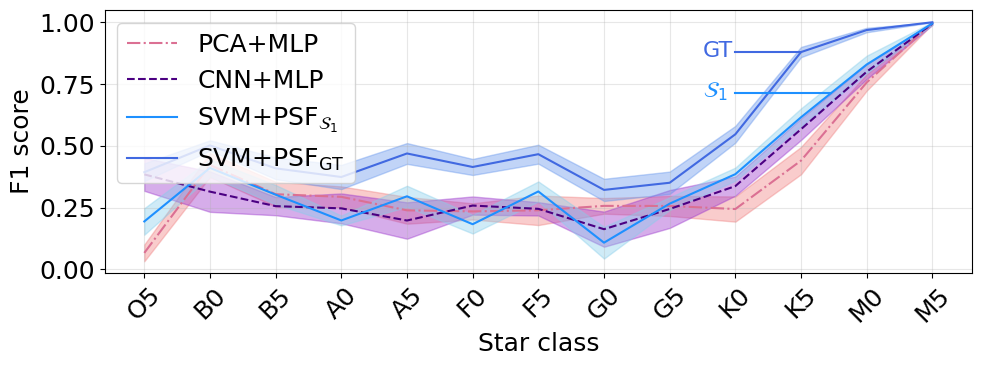

In [193]:
# plot the f1 resuts
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,4))
plt.grid(alpha=0.3)
plt.plot(np.arange(13), f1_PCA, label='PCA+MLP', linestyle='-.', color=pca_color)
plt.fill_between(np.arange(13), f1_PCA-f1_PCA_std, f1_PCA+f1_PCA_std, alpha=0.4, color=pca_color_2)

plt.plot(np.arange(13), f1_CNN, label='CNN+MLP', color=cnn_color, linestyle='--')
plt.fill_between(np.arange(13), f1_CNN-f1_CNN_std, f1_CNN+f1_CNN_std, alpha=0.4, color=cnn_color_2)

plt.plot(np.arange(13), f1_SVM_list[0], label=r'SVM+PSF$_{\mathcal{S}_1}$', color=svm_s1_color)
plt.fill_between(np.arange(13), f1_SVM_list[0]-f1_SVM_list_std[0], f1_SVM_list[0]+f1_SVM_list_std[0], alpha=0.4, color=svm_s1_color_2)

plt.plot(np.arange(13), f1_SVM, label=r'SVM+PSF$_{\text{GT}}$', color=svm_color)
plt.fill_between(np.arange(13), f1_SVM-f1_SVM_std, f1_SVM+f1_SVM_std, alpha=0.4, color=svm_color_2)



plt.legend(loc='upper left')

plt.xlabel('Star class')
plt.xticks(np.arange(13), star_class_labels, rotation=45)

plt.ylabel('F1 score')
# plt.yticks([0, .5, 1], ['0', '0.5', '1'])

# Add line to point out GT and S1
line_gt = [[9,10],[f1_SVM[10],f1_SVM[10]]]
plt.plot(line_gt[0], line_gt[1], linestyle='-', color=svm_color)
plt.text(8.5, f1_SVM[10]-.02, 'GT', fontsize=16, color=svm_color)

line_s1 = [[9,10.45],[f1_SVM_list[0][10]+.1,f1_SVM_list[0][10]+.1]]
plt.plot(line_s1[0], line_s1[1], linestyle='-', color=svm_s1_color)
plt.text(8.5, f1_SVM_list[0][10]-.02+.1, r'$\mathcal{S}_1$', fontsize=16, color=svm_s1_color)

plt.tight_layout()
# plt.show()
plt.savefig('../figures/f1_score.pdf')

# Accuracy per class

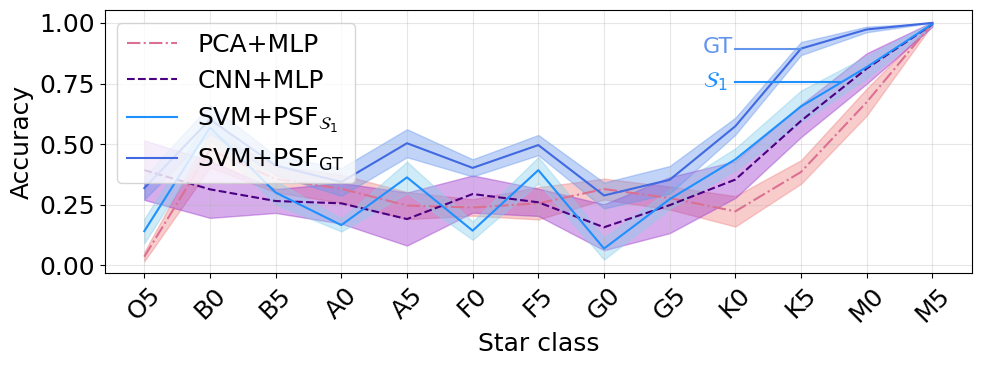

In [145]:
# Svm accuracy per class
accuracy_per_class_svm_gt = np.mean([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_gt], axis=0)
accuracy_per_class_std_svm_gt = np.std([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_gt], axis=0)
accuracy_per_class_smv_s1 = np.mean([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_SVM.swapaxes(0,1)[0]], axis=0)
accuracy_per_class_std_smv_s1 = np.std([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_SVM.swapaxes(0,1)[0]], axis=0)

# CNN accuracy per class
accuracy_per_class_cnn = np.mean([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_CNN_list], axis=0)
accuracy_per_class_std_cnn = np.std([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_CNN_list], axis=0)

# PCA accuracy per class
accuracy_per_class_pca = np.mean([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_PCA_list], axis=0)
accuracy_per_class_std_pca = np.std([np.diag(rand_cm)/np.sum(rand_cm, axis=1) for rand_cm in cm_PCA_list], axis=0)

# Plot the accuracy per class results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,4))
plt.grid(alpha=0.3)
plt.plot(np.arange(13), accuracy_per_class_pca, label='PCA+MLP', linestyle='-.', color='palevioletred')
plt.fill_between(np.arange(13), accuracy_per_class_pca-accuracy_per_class_std_pca, accuracy_per_class_pca+accuracy_per_class_std_pca, alpha=0.4, color='lightcoral')

plt.plot(np.arange(13), accuracy_per_class_cnn, label='CNN+MLP', color='indigo', linestyle='--')
plt.fill_between(np.arange(13), accuracy_per_class_cnn-accuracy_per_class_std_cnn, accuracy_per_class_cnn+accuracy_per_class_std_cnn, alpha=0.4, color='darkorchid')

plt.plot(np.arange(13), accuracy_per_class_smv_s1, label=r'SVM+PSF$_{\mathcal{S}_1}$', color='dodgerblue')
plt.fill_between(np.arange(13), accuracy_per_class_smv_s1-accuracy_per_class_std_smv_s1, accuracy_per_class_smv_s1+accuracy_per_class_std_smv_s1, alpha=0.4, color='skyblue')

plt.plot(np.arange(13), accuracy_per_class_svm_gt, label=r'SVM+PSF$_{\text{GT}}$', color='royalblue')
plt.fill_between(np.arange(13), accuracy_per_class_svm_gt-accuracy_per_class_std_svm_gt, accuracy_per_class_svm_gt+accuracy_per_class_std_svm_gt, alpha=0.4, color='cornflowerblue')

plt.legend(loc='upper left')

plt.xlabel('Star class')
plt.xticks(np.arange(13), star_class_labels, rotation=45)

plt.ylabel('Accuracy')
# plt.yticks([0, .5, 1], ['0', '0.5', '1'])

# Add line to point out GT and S1
line_gt = [[9,10],[accuracy_per_class_svm_gt[10],accuracy_per_class_svm_gt[10]]]
plt.plot(line_gt[0], line_gt[1], linestyle='-', color='cornflowerblue')
plt.text(8.5, accuracy_per_class_svm_gt[10]-.02, 'GT', fontsize=16, color='cornflowerblue')

line_s1 = [[9,10.6],[accuracy_per_class_smv_s1[10]+.1,accuracy_per_class_smv_s1[10]+.1]]
plt.plot(line_s1[0], line_s1[1], linestyle='-', color='dodgerblue')
plt.text(8.5, accuracy_per_class_smv_s1[10]-.02+.1, r'$\mathcal{S}_1$', fontsize=16, color='dodgerblue')

plt.tight_layout()
# plt.show()
plt.savefig('../figures/accuracy_per_class.pdf')



In [161]:
print('Acc per class:', 'O5  ','B0   ','B5   ','A0   ','A5   ','F0   ','F5   ','G0   ','G5   ','K0   ','K5   ','M0   ','M5   ')
print('PCA:          {} {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(accuracy_per_class_pca, 2)))
print('CNN:          {} {}  {}  {}  {}  {}  {}  {}  {}  {}  {}   {}  {}'.format(*np.around(accuracy_per_class_cnn, 2)))
print('SVM s1:       {} {}   {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(accuracy_per_class_smv_s1, 2)))
print('SVM:          {} {}   {}  {}   {}   {}  {}   {}  {}  {}  {}  {}  {}'.format(*np.around(accuracy_per_class_svm_gt, 2)))

Acc per class: O5   B0    B5    A0    A5    F0    F5    G0    G5    K0    K5    M0    M5   
PCA:          0.04 0.48  0.36  0.32  0.25  0.24  0.26  0.31  0.28  0.22  0.39  0.67  1.0
CNN:          0.39 0.31  0.27  0.26  0.19  0.29  0.26  0.16  0.25  0.35  0.6   0.81  0.99
SVM s1:       0.14 0.57   0.3  0.17  0.36  0.14  0.39  0.07  0.27  0.44  0.66  0.82  1.0
SVM:          0.32 0.6   0.41  0.34   0.5   0.4  0.5   0.29  0.35  0.57  0.89  0.97  1.0


# Top-2 accuracy per class

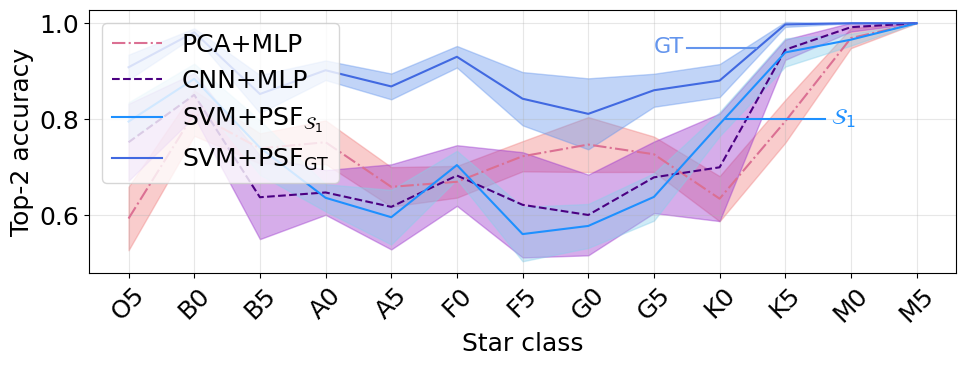

In [146]:
# SVM top-2 accuracy per class
top_2_accuracy_per_class_svm_gt = np.mean([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_gt], axis=0)
top_2_accuracy_per_class_std_svm_gt = np.std([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_gt], axis=0)
top_2_accuracy_per_class_smv_s1 = np.mean([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_SVM.swapaxes(0,1)[0]], axis=0)
top_2_accuracy_per_class_std_smv_s1 = np.std([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_SVM.swapaxes(0,1)[0]], axis=0)

# CNN top-2 accuracy per class
top_2_accuracy_per_class_cnn = np.mean([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_CNN_list], axis=0)
top_2_accuracy_per_class_std_cnn = np.std([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_CNN_list], axis=0)

# PCA top-2 accuracy per class
top_2_accuracy_per_class_pca = np.mean([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_PCA_list], axis=0)
top_2_accuracy_per_class_std_pca = np.std([(np.append(0,np.diag(rand_cm, k=-1)) + np.diag(rand_cm) + np.append(np.diag(rand_cm, k=1),0)) / np.sum(rand_cm, axis=1) for rand_cm in cm_PCA_list], axis=0)

# Plot the top-2 accuracy per class results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,4))
plt.grid(alpha=0.3)
plt.plot(np.arange(13), top_2_accuracy_per_class_pca, label='PCA+MLP', linestyle='-.', color='palevioletred')
plt.fill_between(np.arange(13), top_2_accuracy_per_class_pca-top_2_accuracy_per_class_std_pca, top_2_accuracy_per_class_pca+top_2_accuracy_per_class_std_pca, alpha=0.4, color='lightcoral')

plt.plot(np.arange(13), top_2_accuracy_per_class_cnn, label='CNN+MLP', color='indigo', linestyle='--')
plt.fill_between(np.arange(13), top_2_accuracy_per_class_cnn-top_2_accuracy_per_class_std_cnn, top_2_accuracy_per_class_cnn+top_2_accuracy_per_class_std_cnn, alpha=0.4, color='darkorchid')

plt.plot(np.arange(13), top_2_accuracy_per_class_smv_s1, label=r'SVM+PSF$_{\mathcal{S}_1}$', color='dodgerblue')
plt.fill_between(np.arange(13), top_2_accuracy_per_class_smv_s1-top_2_accuracy_per_class_std_smv_s1, top_2_accuracy_per_class_smv_s1+top_2_accuracy_per_class_std_smv_s1, alpha=0.4, color='skyblue')

plt.plot(np.arange(13), top_2_accuracy_per_class_svm_gt, label=r'SVM+PSF$_{\text{GT}}$', color='royalblue')
plt.fill_between(np.arange(13), top_2_accuracy_per_class_svm_gt-top_2_accuracy_per_class_std_svm_gt, top_2_accuracy_per_class_svm_gt+top_2_accuracy_per_class_std_svm_gt, alpha=0.4, color='cornflowerblue')

plt.legend(loc='upper left')

plt.xlabel('Star class')
plt.xticks(np.arange(13), star_class_labels, rotation=45)

plt.ylabel('Top-2 accuracy')
# plt.yticks([0, .5, 1], ['0', '0.5', '1'])

# Add line to point out GT and S1
line_gt = [[8.5,9.55],[top_2_accuracy_per_class_svm_gt[10]-.05,top_2_accuracy_per_class_svm_gt[10]-.05]]
plt.plot(line_gt[0], line_gt[1], linestyle='-', color='cornflowerblue')
plt.text(8, top_2_accuracy_per_class_svm_gt[10]-.06, 'GT', fontsize=16, color='cornflowerblue')

line_s1 = [[9.1,10.6],[.8,.8]]
plt.plot(line_s1[0], line_s1[1], linestyle='-', color='dodgerblue')
plt.text(10.7, .79, r'$\mathcal{S}_1$', fontsize=16, color='dodgerblue')

plt.tight_layout()
# plt.show()

plt.savefig('../figures/top_2_accuracy_per_class.pdf')


In [175]:
print('top2 p class:', 'O5  ','B0   ','B5   ','A0   ','A5   ','F0   ','F5   ','G0   ','G5   ','K0   ','K5   ','M0   ','M5   ')
print('PCA:          {} {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}  {}'.format(*np.around(top_2_accuracy_per_class_pca, 2)))
print('CNN:          {} {}  {}  {}  {}  {}  {}  {}   {}  {}   {} {}  {}'.format(*np.around(top_2_accuracy_per_class_cnn, 2)))
print('SVM s1:       {}  {}  {}  {}  {}   {}   {}  {}  {}  {}  {} {}  {}'.format(*np.around(top_2_accuracy_per_class_smv_s1, 2)))
print('SVM:          {} {}  {}  {}   {}  {}  {}  {}  {}  {}  {}  {}   {}'.format(*np.around(top_2_accuracy_per_class_svm_gt, 2)))

top2 p class: O5   B0    B5    A0    A5    F0    F5    G0    G5    K0    K5    M0    M5   
PCA:          0.59 0.81  0.74  0.75  0.66  0.67  0.72  0.75  0.73  0.63  0.8  0.97  1.0
CNN:          0.75 0.85  0.64  0.65  0.62  0.68  0.62  0.6   0.68  0.7   0.94 0.99  1.0
SVM s1:       0.8  0.88  0.74  0.64  0.6   0.7   0.56  0.58  0.64  0.79  0.94 0.97  1.0
SVM:          0.91 0.98  0.85  0.9   0.87  0.93  0.84  0.81  0.86  0.88  1.0  1.0   1.0


In [30]:
# # Other models metrics
# cm_CNN = np.load('CNN_pix_classifier_cm.npy')
# accuracy_CNN = np.trace(cm_CNN)/np.sum(cm_CNN)
# relaxed_accuracy_CNN = (np.trace(cm_CNN, offset=1) + np.trace(cm_CNN, offset=-1) + np.trace(cm_CNN) )/ np.sum(cm_CNN)

# cm_PCA = np.load('PCA_pix_classifier_cm.npy')
# accuracy_PCA = np.trace(cm_PCA)/np.sum(cm_PCA)
# relaxed_accuracy_PCA = (np.trace(cm_PCA, offset=1) + np.trace(cm_PCA, offset=-1) + np.trace(cm_PCA) )/ np.sum(cm_PCA)

# # Define plot font size
# plt.rcParams.update({'font.size': 12})

# # compute the prediction confidence
# low_confidence_bar_relaxed = (1-np.array(confidence_relaxed_list+[confidence_relaxed_gt]))*np.array(relaxed_accuracy_list+[relaxed_accuracy_gt])
# low_confidence_bar = (1-np.array(confidence_list+[confidence_gt]))*np.array(accuracy_list+[accuracy_gt])
# up_confidence_bar = (np.array(p_miss_list+[p_miss_gt]))*(1-np.array(accuracy_list+[accuracy_gt]))
# up_confidence_bar_relaxed = (np.array(p_miss_relaxed_list+[p_miss_relaxed_gt]))*(1-np.array(relaxed_accuracy_list+[relaxed_accuracy_gt]))

# # Plot the accuracy for each dataset
# plt.figure(figsize=(8,5))
# plt.plot(n_stars_list+[4000], accuracy_list+[accuracy_gt], color='royalblue', label='SVM accuracy')
# plt.fill_between(n_stars_list+[4000], accuracy_list+[accuracy_gt]-low_confidence_bar, accuracy_list+[accuracy_gt], color='cornflowerblue' ,alpha=0.3)
# plt.fill_between(n_stars_list+[4000], accuracy_list+[accuracy_gt], accuracy_list+[accuracy_gt]+up_confidence_bar, color='cornflowerblue' ,alpha=0.3)
# plt.axhline(y=accuracy_PCA, color='cornflowerblue', linestyle='-.', label='PCA+FCN accuracy')
# plt.axhline(y=accuracy_CNN, color='cornflowerblue', linestyle='--', label='CNN accuracy')
# plt.plot(n_stars_list+[4000], relaxed_accuracy_list+[relaxed_accuracy_gt], color='darkgoldenrod', label='SVM Top-2 accuracy')
# plt.fill_between(n_stars_list+[4000], relaxed_accuracy_list+[relaxed_accuracy_gt]-low_confidence_bar_relaxed, relaxed_accuracy_list+[relaxed_accuracy_gt], color='goldenrod' ,alpha=0.3)
# plt.fill_between(n_stars_list+[4000], relaxed_accuracy_list+[relaxed_accuracy_gt], relaxed_accuracy_list+[relaxed_accuracy_gt]+up_confidence_bar_relaxed, color='goldenrod' ,alpha=0.3)
# plt.axhline(y=relaxed_accuracy_PCA, color='goldenrod', linestyle='-.', label='PCA+FCN Top-2 accuracy')
# plt.axhline(y=relaxed_accuracy_CNN, color='goldenrod', linestyle='--', label='CNN Top-2 accuracy')
# plt.xlabel('Number of stars in the training set')
# plt.xscale('log')
# plt.ylabel('Classification accuracy')
# plt.ylim(0,1)
# plt.xticks(n_stars_list+[4000], n_stars_list+['GT PSF'])
# plt.title('SVM accuracy vs number of stars in the PSF training set')
# plt.grid()
# plt.legend(loc='lower right')
# plt.show()

In [31]:

# # Plot the accuracy for each dataset
# plt.figure(figsize=(8,5))
# plt.plot(rel_err_1x+[0], accuracy_list+[accuracy_gt], color='royalblue', label='SVM accuracy')
# plt.fill_between(rel_err_1x+[0], accuracy_list+[accuracy_gt]-low_confidence_bar, accuracy_list+[accuracy_gt], color='cornflowerblue' ,alpha=0.3)
# plt.fill_between(rel_err_1x+[0], accuracy_list+[accuracy_gt], accuracy_list+[accuracy_gt]+up_confidence_bar, color='cornflowerblue' ,alpha=0.3)
# plt.axhline(y=accuracy_PCA, color='cornflowerblue', linestyle='-.', label='PCA+FCN accuracy')
# plt.axhline(y=accuracy_CNN, color='cornflowerblue', linestyle='--', label='CNN accuracy')
# plt.plot(rel_err_1x+[0], relaxed_accuracy_list+[relaxed_accuracy_gt], color='darkgoldenrod', label='SVM Top-2 accuracy')
# plt.fill_between(rel_err_1x+[0], relaxed_accuracy_list+[relaxed_accuracy_gt]-low_confidence_bar_relaxed, relaxed_accuracy_list+[relaxed_accuracy_gt], color='goldenrod' ,alpha=0.3)
# plt.fill_between(rel_err_1x+[0], relaxed_accuracy_list+[relaxed_accuracy_gt], relaxed_accuracy_list+[relaxed_accuracy_gt]+up_confidence_bar_relaxed, color='goldenrod' ,alpha=0.3)
# plt.axhline(y=relaxed_accuracy_PCA, color='goldenrod', linestyle='-.', label='PCA+FCN Top-2 accuracy')
# plt.axhline(y=relaxed_accuracy_CNN, color='goldenrod', linestyle='--', label='CNN Top-2 accuracy')
# plt.xlabel('PSF model error [%]')
# plt.ylabel('Classification accuracy')
# plt.ylim(0,1)
# plt.xticks(rel_err_1x+[0], np.round(rel_err_1x+[0],1))
# plt.title('SVM accuracy vs PSF model error')
# # invert x axis
# plt.gca().invert_xaxis()
# plt.grid()
# plt.legend(loc='lower right')
# plt.show()

# Random realisation results

In [53]:
# Join SVM and GT PSF model metrics
mean_accuracy = np.append(accuracy_SVM_list, accuracy_gt)
std_accuracy = np.append(accuracy_std_SVM_list, accuracy_std_gt)
mean_relaxed_accuracy = np.append(relaxed_accuracy_SVM_list, relaxed_accuracy_gt)
std_relaxed_accuracy = np.append(relaxed_accuracy_std_SVM_list, relaxed_accuracy_std_gt)


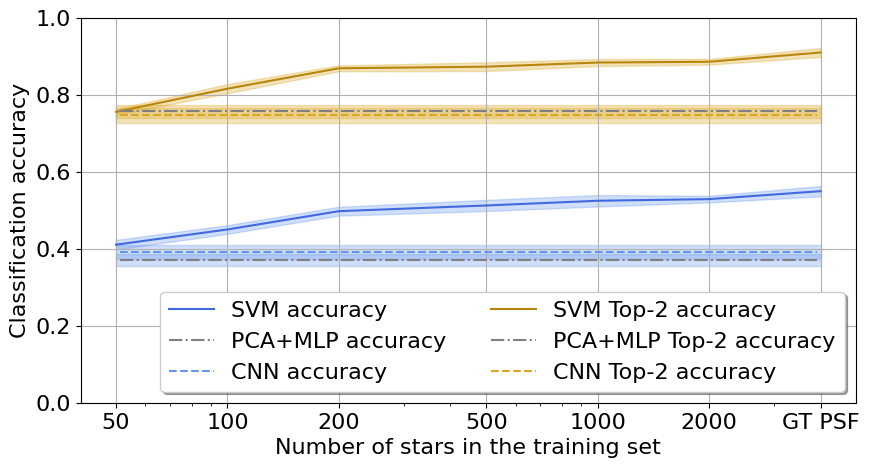

In [56]:
# Plot the accuracy for each dataset
plt.figure(figsize=(10,5))
plt.plot(n_stars_list+[4000], mean_accuracy, color='royalblue', label='SVM accuracy')
plt.fill_between(n_stars_list+[4000], mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, color='cornflowerblue' ,alpha=0.3)

plt.axhline(y=accuracy_PCA_mean, xmin=0.05, xmax=.95, color='gray', linestyle='-.', label='PCA+MLP accuracy')
plt.fill_between(n_stars_list+[4000], accuracy_PCA_mean-accuracy_PCA_std, accuracy_PCA_mean+accuracy_PCA_std, color='cornflowerblue' ,alpha=0.3)

plt.axhline(y=accuracy_CNN_mean, xmin=0.05, xmax=.95, color='cornflowerblue', linestyle='--', label='CNN accuracy')
plt.fill_between(n_stars_list+[4000], accuracy_CNN_mean-accuracy_CNN_std, accuracy_CNN_mean+accuracy_CNN_std, color='cornflowerblue' ,alpha=0.3)

plt.plot(n_stars_list+[4000], mean_relaxed_accuracy, color='darkgoldenrod', label='SVM Top-2 accuracy')
plt.fill_between(n_stars_list+[4000], mean_relaxed_accuracy-std_relaxed_accuracy, mean_relaxed_accuracy+std_relaxed_accuracy, color='goldenrod' ,alpha=0.3)

plt.axhline(y=relaxed_accuracy_PCA_mean, xmin=0.05, xmax=.95, color='gray', linestyle='-.', label='PCA+MLP Top-2 accuracy')
plt.fill_between(n_stars_list+[4000], relaxed_accuracy_PCA_mean-relaxed_accuracy_PCA_std, relaxed_accuracy_PCA_mean+relaxed_accuracy_PCA_std, color='goldenrod' ,alpha=0.3)

plt.axhline(y=relaxed_accuracy_CNN_mean, xmin=0.05, xmax=.95, color='goldenrod', linestyle='--', label='CNN Top-2 accuracy')
plt.fill_between(n_stars_list+[4000], relaxed_accuracy_CNN_mean-relaxed_accuracy_CNN_std, relaxed_accuracy_CNN_mean+relaxed_accuracy_CNN_std, color='goldenrod' ,alpha=0.3)

plt.xlabel('Number of stars in the training set')
plt.xscale('log')
plt.ylabel('Classification accuracy')
plt.ylim(0,1)
plt.xticks(n_stars_list+[4000], n_stars_list+['GT PSF'])
# plt.title('Accuracy vs PSF model error', fontsize=22)
plt.grid()
plt.legend(loc='lower right', ncol=2, fancybox=True, shadow=True, bbox_to_anchor=(1, 0))
plt.show()

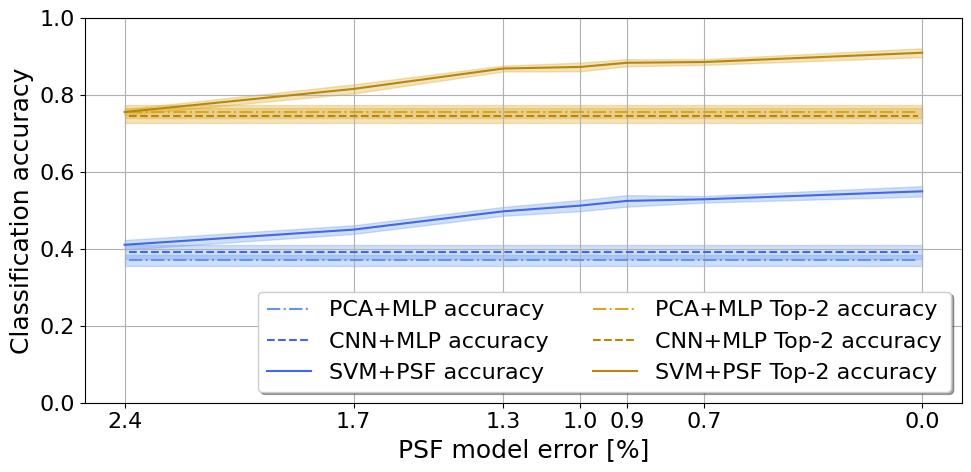

In [58]:
rel_err_1x = np.load('../approx_PSF_models/rel_err_1x.npy').tolist()
plt.rcParams.update({'font.size': 16})

# Plot the accuracy for each dataset
plt.figure(figsize=(10,5))

plt.axhline(y=accuracy_PCA_mean, xmin=0.05, xmax=.95, color='cornflowerblue', linestyle='-.', label='PCA+MLP accuracy')
plt.fill_between(rel_err_1x+[0], accuracy_PCA_mean-accuracy_PCA_std, accuracy_PCA_mean+accuracy_PCA_std, color='cornflowerblue' ,alpha=0.3)

plt.axhline(y=accuracy_CNN_mean, xmin=0.05, xmax=.95, color='royalblue', linestyle='--', label='CNN+MLP accuracy')
plt.fill_between(rel_err_1x+[0], accuracy_CNN_mean-accuracy_CNN_std, accuracy_CNN_mean+accuracy_CNN_std, color='cornflowerblue' ,alpha=0.3)

plt.plot(rel_err_1x+[0], mean_accuracy, color='royalblue', label='SVM+PSF accuracy')
plt.fill_between(rel_err_1x+[0], mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, color='cornflowerblue' ,alpha=0.3)

plt.axhline(y=relaxed_accuracy_PCA_mean, xmin=0.05, xmax=.95, color='goldenrod', linestyle='-.', label='PCA+MLP Top-2 accuracy')
plt.fill_between(rel_err_1x+[0], relaxed_accuracy_PCA_mean-relaxed_accuracy_PCA_std, relaxed_accuracy_PCA_mean+relaxed_accuracy_PCA_std, color='goldenrod' ,alpha=0.3)

plt.axhline(y=relaxed_accuracy_CNN_mean, xmin=0.05, xmax=.95, color='darkgoldenrod', linestyle='--', label='CNN+MLP Top-2 accuracy')
plt.fill_between(rel_err_1x+[0], relaxed_accuracy_CNN_mean-relaxed_accuracy_CNN_std, relaxed_accuracy_CNN_mean+relaxed_accuracy_CNN_std, color='goldenrod' ,alpha=0.3)

plt.plot(rel_err_1x+[0], mean_relaxed_accuracy, color='darkgoldenrod', label='SVM+PSF Top-2 accuracy')
plt.fill_between(rel_err_1x+[0], mean_relaxed_accuracy-std_relaxed_accuracy, mean_relaxed_accuracy+std_relaxed_accuracy, color='goldenrod' ,alpha=0.3)

plt.xlabel('PSF model error [%]', fontsize=18)
plt.ylabel('Classification accuracy', fontsize=18)
plt.ylim(0,1)
plt.xticks(rel_err_1x+[0], np.round(rel_err_1x+[0],1))
# plt.title('Accuracy vs PSF model error', fontsize=22)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(loc='lower right', ncol=2, fancybox=True, shadow=True, bbox_to_anchor=(1, 0))
# plt.show()
plt.tight_layout()
# plt.savefig('../figures/SVM_accuracy_vs_PSF_error.pdf')

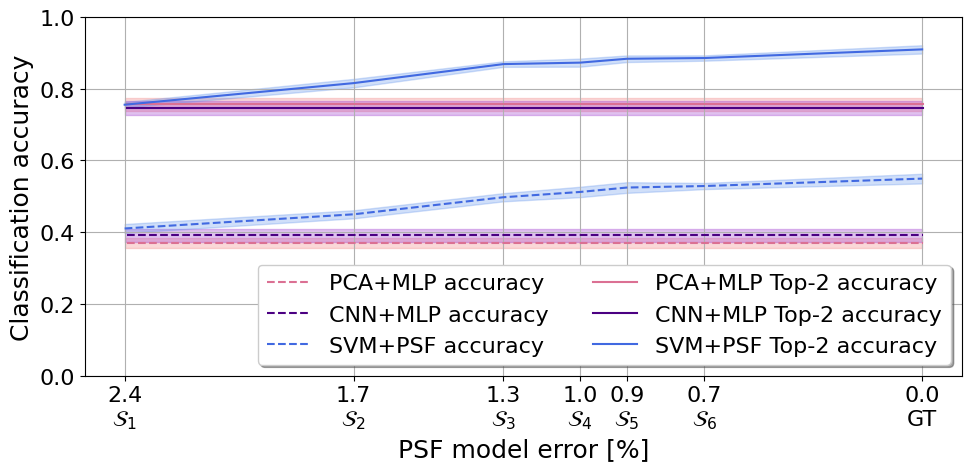

In [89]:
rel_err_1x = np.load('../approx_PSF_models/rel_err_1x.npy').tolist()
plt.rcParams.update({'font.size': 16})

# Plot the accuracy for each dataset
plt.figure(figsize=(10,5))

plt.axhline(y=accuracy_PCA_mean, xmin=0.048, xmax=.955, color='palevioletred', linestyle='--', label='PCA+MLP accuracy')
plt.fill_between(rel_err_1x+[0], accuracy_PCA_mean-accuracy_PCA_std, accuracy_PCA_mean+accuracy_PCA_std, color='lightcoral' ,alpha=0.3)

plt.axhline(y=accuracy_CNN_mean, xmin=0.048, xmax=.955, color='indigo', linestyle='--', label='CNN+MLP accuracy')
plt.fill_between(rel_err_1x+[0], accuracy_CNN_mean-accuracy_CNN_std, accuracy_CNN_mean+accuracy_CNN_std, color='darkorchid' ,alpha=0.3)

plt.plot(rel_err_1x+[0], mean_accuracy, color='royalblue', linestyle='--', label='SVM+PSF accuracy')
plt.fill_between(rel_err_1x+[0], mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, color='cornflowerblue' ,alpha=0.3)

plt.axhline(y=relaxed_accuracy_PCA_mean, xmin=0.048, xmax=.955, color='palevioletred', linestyle='-', label='PCA+MLP Top-2 accuracy')
plt.fill_between(rel_err_1x+[0], relaxed_accuracy_PCA_mean-relaxed_accuracy_PCA_std, relaxed_accuracy_PCA_mean+relaxed_accuracy_PCA_std, color='lightcoral' ,alpha=0.3)

plt.axhline(y=relaxed_accuracy_CNN_mean, xmin=0.048, xmax=.955, color='indigo', linestyle='-', label='CNN+MLP Top-2 accuracy')
plt.fill_between(rel_err_1x+[0], relaxed_accuracy_CNN_mean-relaxed_accuracy_CNN_std, relaxed_accuracy_CNN_mean+relaxed_accuracy_CNN_std, color='darkorchid' ,alpha=0.3)

plt.plot(rel_err_1x+[0], mean_relaxed_accuracy, color='royalblue', label='SVM+PSF Top-2 accuracy')
plt.fill_between(rel_err_1x+[0], mean_relaxed_accuracy-std_relaxed_accuracy, mean_relaxed_accuracy+std_relaxed_accuracy, color='cornflowerblue' ,alpha=0.3)

plt.xlabel('PSF model error [%]', fontsize=18)
plt.ylabel('Classification accuracy', fontsize=18)
plt.ylim(0,1)
plt.xticks(rel_err_1x+[0], [str(err_str)+'\n'+r'$\mathcal{{S}}_{{{}}}$'.format(i+1) for i, err_str in enumerate(np.round(rel_err_1x,1))]+['0.0\nGT'])
# plt.title('Accuracy vs PSF model error', fontsize=22)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(loc='lower right', ncol=2, fancybox=True, shadow=True, bbox_to_anchor=(1, 0))
# plt.show()
plt.tight_layout()
plt.savefig('../figures/SVM_accuracy_vs_PSF_error.pdf')

# Visualise features

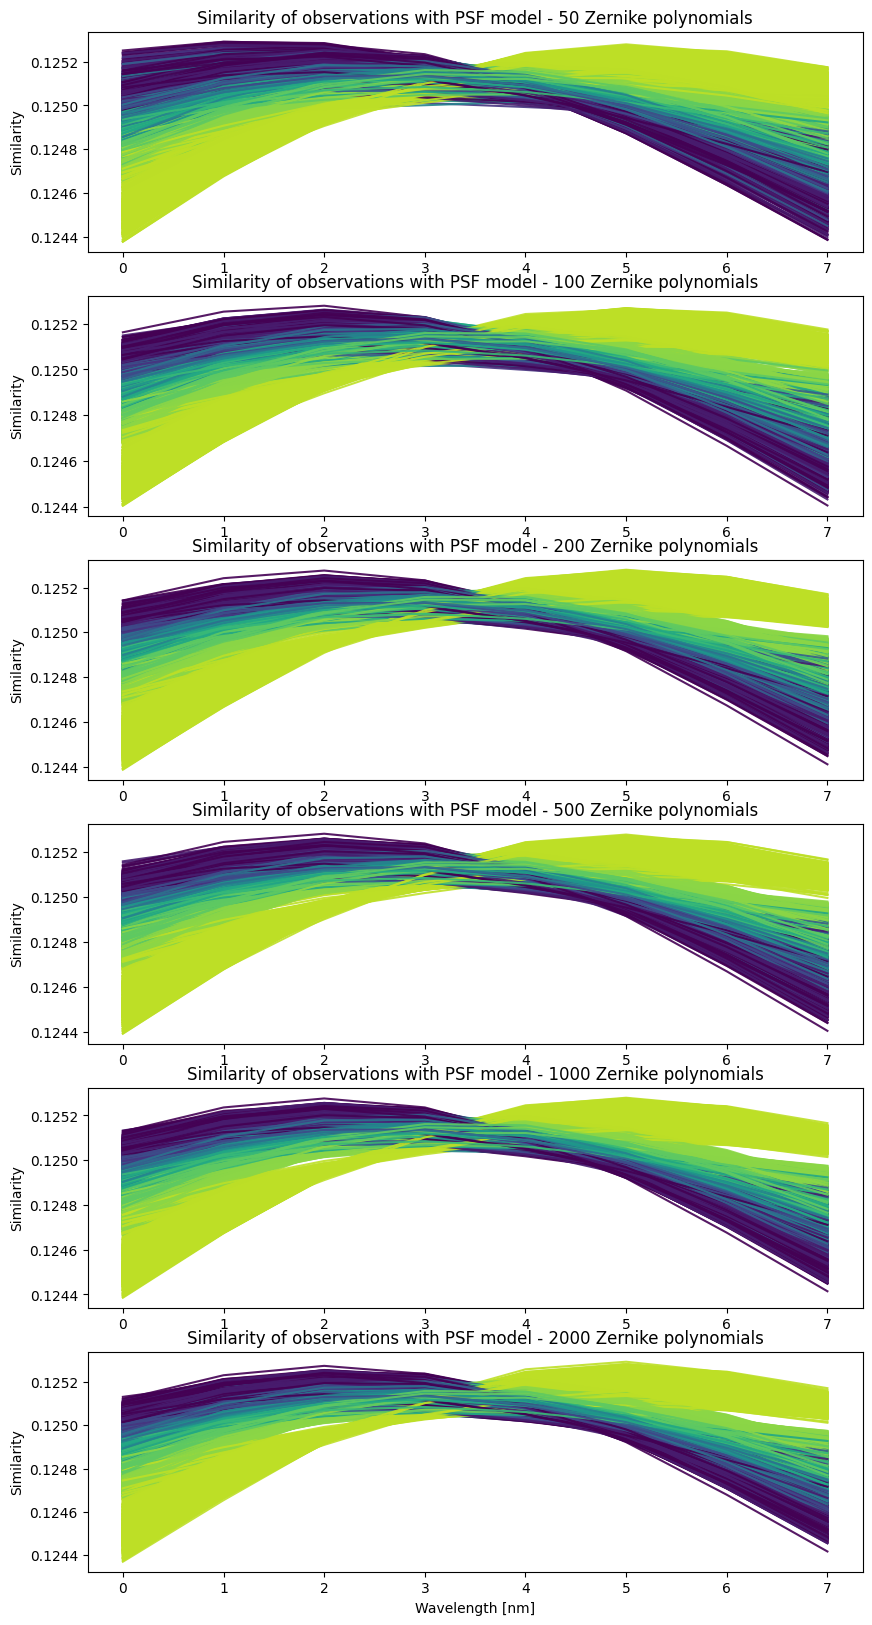

In [20]:
# Define 13 color palette
color_palette = plt.cm.viridis(np.linspace(0, 0.9, 13))

# Plot the difference with color code
fig, ax = plt.subplots(6,1,figsize=(10, 20))
for k, diff_train in enumerate(diff_train_list):
    for i, diff in enumerate(diff_train):
        ax[k].plot(diff, color=color_palette[dataset_gt_train['SED_ids'][train_star_offset+i]], alpha=0.9)

    ax[k].set_title('Similarity of observations with PSF model - {} Zernike polynomials'.format(n_stars_list[k]))
    ax[k].set_ylabel('Similarity')
ax[k].set_xlabel('Wavelength [nm]')
plt.show()